# SVGP Redux for Tract or Block Group Data


In [1]:
# Imports
import torch
from tqdm import  tqdm
import pyro
import pyro.distributions as dist
import gpytorch
import pandas as pd
import geopandas as gpd
from torch.utils.data import DataLoader
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ZeroMean
from gpytorch.models import ApproximateGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import GammaPrior
import matplotlib.pyplot as plt
from shapely.geometry import Point

import numpy as np
import pytz
import os, re
from datetime import date
from scipy.stats import pearsonr

import rasterio
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import tempfile
import os

In [2]:
seed = 42  # Choose any fixed integer
np.random.seed(seed)
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
torch.set_default_dtype(torch.float32)

In [3]:
wu_date = 'jul23_2021'
census_group_type = "block_group" # polygons for covariates and 
city_name = 'durham'
county_prefixes = ["37063"] # charlotte: ["37119"], durham: ["37063"], raleigh: ["37183"], asheville: ["37021"], CH: ["37135", "37063", "37037"]
time_slot = 'eve' # morn, af, eve
t_s_col = 't_s_night' if time_slot == 'eve' else 't_s_day'

First let's load the station data:

In [4]:
from datasets.process_wu_data import load_and_filter_wu_data
from datasets.process_wu_data import filter_by_time_slot_local_last5min

# Prepare WU station data for kriging

# 1. Load and quality-filter
obs_wu = load_and_filter_wu_data(f"data/{wu_date}/{wu_date}_wu.csv")

_MON = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,
        "jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

def wu_date_to_target_date(wu_date: str) -> str:
    """
    Convert things like 'jul23_2021', 'Jul_23_2021', 'data/jul23_2021',
    or ISO-ish forms ('2021-07-23', '20210723', '2021_07_23')
    into 'YYYY-MM-DD'.
    """
    s = os.path.basename(str(wu_date)).lower()

    # ISO-ish first
    m = re.fullmatch(r"(\d{4})[-_]?(\d{2})[-_]?(\d{2})", s)
    if m:
        y, mth, d = map(int, m.groups())
        return date(y, mth, d).isoformat()

    # monDD_YYYY with optional underscore between mon and DD
    m = re.fullmatch(r"([a-z]{3})_?(\d{1,2})_(\d{4})", s)
    if m:
        mon, d, y = m.groups()
        mm = _MON.get(mon)
        if mm is None:
            raise ValueError(f"Unknown month abbr: {mon}")
        return date(int(y), mm, int(d)).isoformat()

    # Embedded patterns inside longer strings
    m = re.search(r"([a-z]{3})_?(\d{1,2})_(\d{4})", s)
    if m:
        mon, d, y = m.groups()
        mm = _MON.get(mon)
        if mm:
            return date(int(y), mm, int(d)).isoformat()

    m = re.search(r"(\d{4})[-_]?(\d{2})[-_]?(\d{2})", s)
    if m:
        y, mth, d = map(int, m.groups())
        return date(y, mth, d).isoformat()

    raise ValueError(f"Could not parse wu_date: {wu_date}")

target_date = wu_date_to_target_date(wu_date)
print(target_date)

# 2. Apply the standard slot filter (e.g. “eve”)
obs_slot = filter_by_time_slot_local_last5min(
    obs_wu, target_date=target_date, slot=time_slot, tz="America/New_York"
)

# 3. Aggregate to one temperature value per station
stations = (
    obs_slot
    .groupby("station", as_index=False)
    .agg({
        "lat": "median",
        "lon": "median",
        "tempAvg": "median"
    })
)

print(f"{len(stations)} stations kept after QC and slot filtering.")
print(len(obs_slot))


2021-07-23
2715 stations kept after QC and slot filtering.
2715


Now let's load the covariate data (polygon-form):

In [5]:
# ---- Build df_full (one row per polygon) ----

# 1) Load polygon-level csvs
if census_group_type == "tract":
    df_geo  = pd.read_csv(f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.csv")   # has GEOID, {time_slot}_temp, population, count
    df_elev = pd.read_csv(f"data/{wu_date}/nc_tracts_elev_{t_s_col}_{time_slot}.csv")  # has GEOID, elevation, {t_s_col}
else:
    df_geo  = pd.read_csv(f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.csv")
    df_elev = pd.read_csv(f"data/{wu_date}/nc_bg_elev_{t_s_col}_{time_slot}.csv")

for df in (df_geo, df_elev):
    df["GEOID"] = df["GEOID"].astype(str)

# 2) Read polygons, drop pure-water GEOIDs
shp_file = f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.shp" if census_group_type=="tract" else f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.shp"
areal_units = gpd.read_file(shp_file).copy()
areal_units["GEOID"] = areal_units["GEOID"].astype(str)
water_ids = set(areal_units.loc[(areal_units["ALAND"]==0) & (areal_units["AWATER"]>0), "GEOID"])
areal_units = areal_units.loc[~areal_units["GEOID"].isin(water_ids)]
# keep dfs in sync with water removal
df_geo  = df_geo.loc[~df_geo["GEOID"].isin(water_ids)].copy()
df_elev = df_elev.loc[~df_elev["GEOID"].isin(water_ids)].copy()

# 3) Compute centroids in WGS84
units_m  = areal_units.to_crs("EPSG:3857")
units_m["centroid"] = units_m.geometry.centroid
cent_ll  = units_m.set_geometry("centroid").to_crs("EPSG:4326")
areal_units["cent_lon"] = cent_ll.geometry.x
areal_units["cent_lat"] = cent_ll.geometry.y

# 4) Merge everything to make df_full
df_full = (
    df_geo.merge(df_elev[["GEOID","elevation", t_s_col]], on="GEOID", how="left")
          .merge(areal_units[["GEOID","cent_lat","cent_lon"]], on="GEOID", how="left")
)

# 5) Impute any missing covariates (leave temperatures alone)
from sklearn.impute import KNNImputer
to_impute = ["elevation", t_s_col]
imp = KNNImputer(n_neighbors=5, weights="distance")
df_full[to_impute] = imp.fit_transform(df_full[to_impute])


Standardize coordinates (station points and centroids) for kriging.

In [6]:
# Fit scaling on station points, then apply that scaling to both stations and centroids
st_np = stations[["lat", "lon"]].to_numpy()
mu_xy  = st_np.mean(axis=0)
std_xy = st_np.std(axis=0) + 1e-12

X_pts_scaled  = (st_np - mu_xy) / std_xy
X_cent_scaled = (df_full[["cent_lat","cent_lon"]].to_numpy() - mu_xy) / std_xy


Load polygon covariate data and attach it to station point data.

In [7]:
# We already have polygons with covariates. Match the station point to the polygon it falls within to get covariates.
gdf_poly = areal_units[["GEOID", "geometry"]].copy()
gdf_poly["elevation"] = df_full.set_index("GEOID").loc[gdf_poly["GEOID"], "elevation"].values
gdf_poly[t_s_col]     = df_full.set_index("GEOID").loc[gdf_poly["GEOID"], t_s_col].values
gdf_poly = gdf_poly.to_crs(4326)

# Station points
gdf_pts = gpd.GeoDataFrame(
    stations.copy(),
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs="EPSG:4326"
)
gdf_pts  = gdf_pts.to_crs(4326)

# Strict containment first
pts_in = gpd.sjoin(gdf_pts, gdf_poly[["GEOID","elevation", t_s_col, "geometry"]],
                   how="left", predicate="within")

# 3) Fix stragglers with a *projected* nearest join
missing = pts_in["GEOID"].isna()
if missing.any():
    print(f"{missing.sum()} unmatched values. Matching to nearest polygon...")

    # Use a metric CRS (NC State Plane is good; Web Mercator also ok)
    METRIC_CRS = "EPSG:32119"  # NC State Plane (meters). Could use 3857 if you prefer.

    pts_miss_proj = gdf_pts.loc[missing].to_crs(METRIC_CRS)
    poly_proj     = gdf_poly.to_crs(METRIC_CRS)

    # (Optional) set a distance cap if you want to keep truly far/out-of-state points unmatched
    MAXD = None  # e.g., 300 (meters) if you want a threshold

    pts_fix = gpd.sjoin_nearest(
        pts_miss_proj,
        poly_proj[["GEOID", "elevation", t_s_col, "geometry"]],
        how="left",
        distance_col="dist_m",
        max_distance=MAXD
    )

    # write back matches (indices line up with original gdf_pts index)
    cols = ["GEOID", "elevation", t_s_col]
    pts_in.loc[missing, cols] = pts_fix[cols].values

    # (optional) keep nearest distances (meters) for QA
    pts_in.loc[missing, "nearest_dist_m"] = pts_fix["dist_m"].values

    still_missing = pts_in["GEOID"].isna().sum()
    print(f"Fixed {missing.sum() - still_missing}; remaining unmatched: {still_missing}")

30 unmatched values. Matching to nearest polygon...
Fixed 30; remaining unmatched: 0


In [8]:
# STANDARDIZE COVARIATES:

# Polygon standardization (as you already do)
elev_mu, elev_sd = df_full["elevation"].mean(), df_full["elevation"].std() + 1e-12
lst_mu,  lst_sd  = df_full[t_s_col].mean(),          df_full[t_s_col].std()  + 1e-12

elev_poly_z = (df_full["elevation"].to_numpy() - elev_mu) / elev_sd
lst_poly_z  = (df_full[t_s_col].to_numpy()      - lst_mu)  / lst_sd

# Attach z-scored covariates back to polygons (for centroids)
df_full["elev_z"] = elev_poly_z
df_full["lst_z"]  = lst_poly_z

# Station covariates → z-score with THE SAME (mu, sd)
elev_pts_z = (pts_in["elevation"].to_numpy() - elev_mu) / elev_sd
lst_pts_z  = (pts_in[t_s_col].to_numpy()      - lst_mu)  / lst_sd


In [9]:
# Stations: [lat_z, lon_z, elev_z, lst_z]
X_pts  = torch.tensor(np.column_stack([X_pts_scaled, elev_pts_z, lst_pts_z]), dtype=torch.float32)
y_pts  = torch.tensor(stations["tempAvg"].to_numpy(), dtype=torch.float32)
# Centroids
X_cent = torch.tensor(
    np.column_stack([
        X_cent_scaled,
        df_full["elev_z"].to_numpy(),
        df_full["lst_z"].to_numpy()
    ]),
    dtype=torch.float32
)


Now we will fit the initial GP (kriging) on the observations. This will give us a kriged mean and variance for each centroid for ALL census tracts.

In [10]:
assert df_full[["cent_lat","cent_lon"]].notna().all().all(), "Missing centroids"
assert np.isfinite(X_pts.numpy()).all() and np.isfinite(y_pts.numpy()).all(), "NaNs in stations"
print(f"{len(stations)} stations → {len(df_full)} polygons")

2715 stations → 7083 polygons


In [11]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch
from tqdm import trange


class KrigeGP(ExactGP):
    def __init__(self, X, y, lik):
        super().__init__(X, y, lik)
        self.mean_module = LinearMean(input_size=3) # mean over (elev_z, lst_z) --> add lat
        # self.covar_module = ScaleKernel(
        #     MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1]) # only lat/lon in kernel (baseline)
        # )
        
        Kspace = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0,1]))
        Kelev  = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=1, active_dims=[2]))
        self.covar_module = Kspace + Kelev

    def forward(self, x):
        # mean = self.mean_module(x[:, 2:4])
        mean_feats = torch.cat([x[:, 0:1], x[:, 2:3], x[:, 3:4]], dim=-1)  # [lat_z, elev_z, lst_z]
        mean = self.mean_module(mean_feats)
        cov  = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)


lik = GaussianLikelihood() # don't set prior on noise for this specifically
model = KrigeGP(X_pts, y_pts, lik)

model.train()
lik.train()
opt = torch.optim.Adam(model.parameters(), lr=0.05)
mll = ExactMarginalLogLikelihood(lik, model)

n_epochs = 300
pbar = trange(n_epochs, desc="Training KrigeGP", leave=True)

for i in pbar:
    opt.zero_grad()
    with gpytorch.settings.cholesky_jitter(1e-4): # avoid numerical warnings
        out = model(X_pts)
        loss = -mll(out, y_pts)
    loss.backward()
    opt.step()
    pbar.set_postfix({"Loss": f"{loss.item():.3f}"})

Training KrigeGP: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s, Loss=1.525]


In [12]:
print("likelihood.noise:", float(lik.noise.item()))
# print("space lengthscales:", model.covar_module.base_kernel.kernels[0].lengthscale.detach().cpu().numpy())
# print("covar lengthscales:", model.covar_module.base_kernel.kernels[1].lengthscale.detach().cpu().numpy())
# print("mean weights [elev,lst]:", model.mean_module.weights.detach().cpu().numpy().ravel())
# print("mean bias:", float(model.mean_module.bias))


likelihood.noise: 0.9332058429718018


In [13]:
model.eval(); lik.eval()
with torch.no_grad():
    post_lat = model(X_cent)  # latent f
    post_obs = lik(model(X_cent))   # observation y = f + noise

m_cent = post_lat.mean.cpu().numpy()
v_cent = post_obs.variance.cpu().numpy()


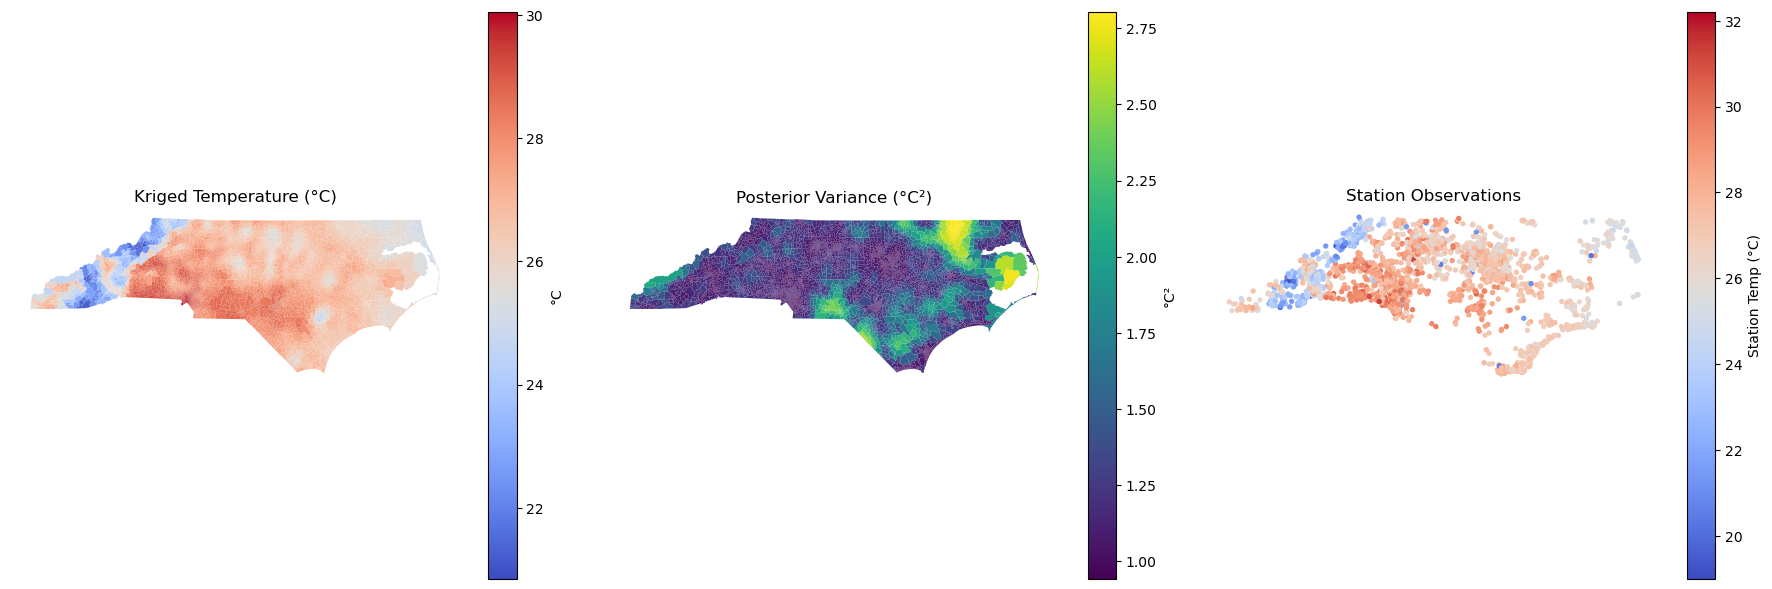

In [14]:
# Attach those predictions to df_full
df_full["krige_mean_C"] = m_cent
df_full["krige_var_C2"] = v_cent

# merge predictions into polygons
gdf_pred = areal_units.merge(
    df_full[["GEOID","krige_mean_C","krige_var_C2"]],
    on="GEOID", how="left"
)

# points GeoDataFrame for stations
gdf_pts = gpd.GeoDataFrame(
    stations.copy(),
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs="EPSG:4326"
)

# pick a common CRS for plotting (Web Mercator)
gdf_pred_pm = gdf_pred.to_crs(3857)
gdf_pts_pm  = gdf_pts.to_crs(3857)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) kriged mean
gdf_pred_pm.plot(
    column="krige_mean_C", cmap="coolwarm", ax=axes[0],
    legend=True, legend_kwds={"label":"°C"}
)
axes[0].set_title("Kriged Temperature (°C)")
axes[0].axis("off")

# 2) posterior variance
gdf_pred_pm.plot(
    column="krige_var_C2", cmap="viridis", ax=axes[1],
    legend=True, legend_kwds={"label":"°C²"}
)
axes[1].set_title("Posterior Variance (°C²)")
axes[1].axis("off")

# 3) station observations (points) over polygon outlines
# gdf_pred_pm.boundary.plot(ax=axes[2], linewidth=0.3, color="lightgray")
sc = gdf_pts_pm.plot(
    ax=axes[2], markersize=8, column="tempAvg", cmap="coolwarm", legend=True,
    legend_kwds={"label":"Station Temp (°C)"}
)
axes[2].set_title("Station Observations")
axes[2].axis("off")

plt.tight_layout()
plt.show()

plt.show()


Plot just in Durham:

In [15]:
# Polygons (tracts or block groups) in just county of interest
# gdf_county = gdf_pred[gdf_pred["GEOID"].astype(str).str.startswith(county_prefix)].copy()
gdf_county = gdf_pred[
    gdf_pred["GEOID"].astype(str).str.startswith(tuple(county_prefixes))
].copy()

# County boundary polygon for clipping points
dur_boundary = gdf_county.dissolve().geometry.iloc[0]

# Reproject both to a geographic CRS (EPSG:4326) before the join
gdf_pts = gdf_pts.to_crs(4326)
gdf_county = gdf_county.to_crs(4326)
gdf_pts_county = gpd.sjoin(
    gdf_pts, gdf_county[["geometry"]], how="inner", predicate="within"
).drop(columns="index_right")

# Project both to Web Mercator for plotting/basemap (optional)
gdf_county_pm = gdf_county.to_crs(3857)
gdf_pts_county_pm = gdf_pts_county.to_crs(3857)


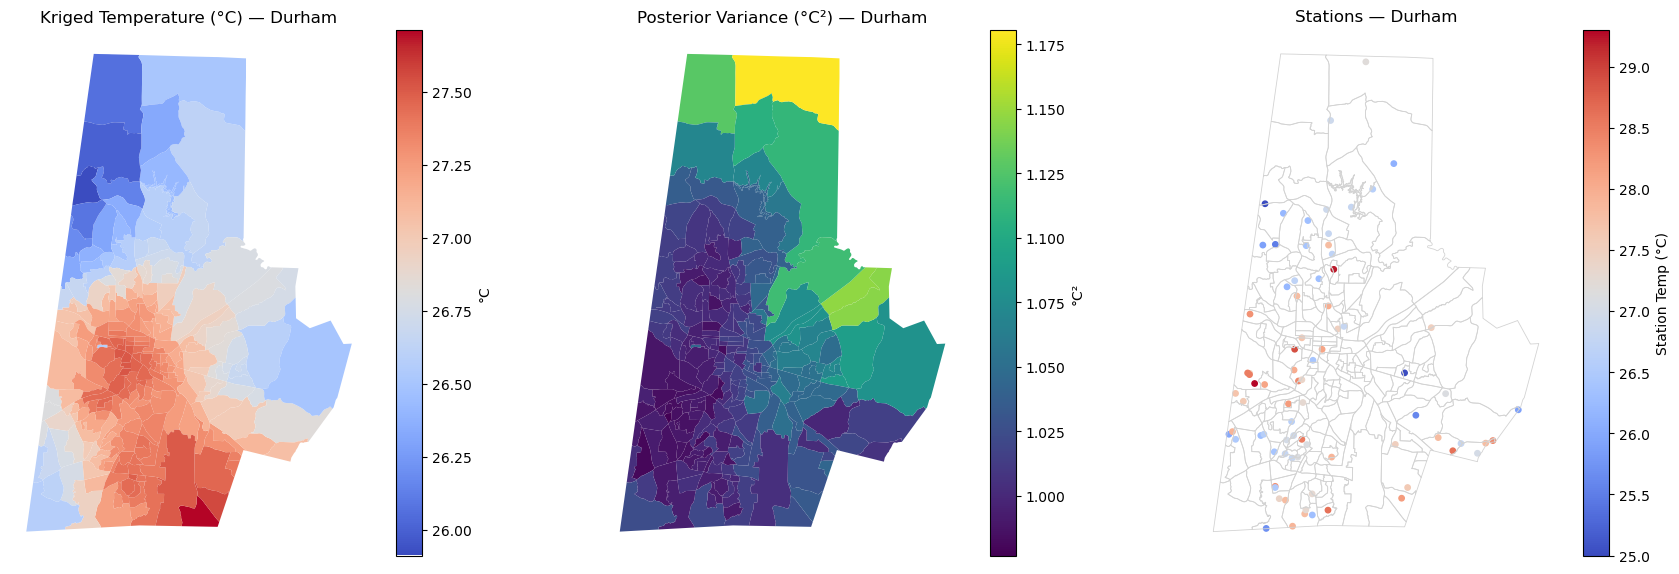

In [16]:
import matplotlib.pyplot as plt

# (optional) fix color scales so the first two panels are comparable across runs
vmin_T = float(gdf_county_pm["krige_mean_C"].min())
vmax_T = float(gdf_county_pm["krige_mean_C"].max())
vmin_V = float(gdf_county_pm["krige_var_C2"].min())
vmax_V = float(gdf_county_pm["krige_var_C2"].max())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Kriged mean (°C)
gdf_county_pm.plot(
    column="krige_mean_C", ax=axes[0], cmap="coolwarm", legend=True,
    legend_kwds={"label": "°C"}, vmin=vmin_T, vmax=vmax_T
)
axes[0].set_title(f"Kriged Temperature (°C) — {city_name.capitalize()}")
axes[0].axis("off")

# 2) Posterior variance (°C²)
gdf_county_pm.plot(
    column="krige_var_C2", ax=axes[1], cmap="viridis", legend=True,
    legend_kwds={"label": "°C²"}, vmin=vmin_V, vmax=vmax_V
)
axes[1].set_title(f"Posterior Variance (°C²) — {city_name.capitalize()}")
axes[1].axis("off")

# 3) Station observations inside Durham
# polygon outline for context
gdf_county_pm.boundary.plot(ax=axes[2], color="lightgray", linewidth=0.6)
gdf_pts_county_pm.plot(
    ax=axes[2], column="tempAvg", cmap="coolwarm", markersize=15, legend=True,
    legend_kwds={"label": "Station Temp (°C)"}
)
axes[2].set_title(f"Stations — {city_name.capitalize()}")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# How can we tell if this is regressing to the mean?

Now we'll fit the SVGP using those kriged values.

In [17]:
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood

# 1) build design matrix X (one row per polygon)
feat_cols = ["cent_lat","cent_lon","elevation", t_s_col, "population", "count"]
X_np = df_full[feat_cols].to_numpy().astype(np.float32)

# scale inputs (but NOT the target)
mu, sd = X_np.mean(0), X_np.std(0) + 1e-12
X = torch.tensor(((X_np - mu)/sd), dtype=torch.float32)

# Feed in kriged mean/var as targets + noise
y = torch.tensor(df_full["krige_mean_C"].to_numpy(), dtype=torch.float32)
noise = torch.tensor(df_full["krige_var_C2"].clip(lower=1e-6).to_numpy(), dtype=torch.float32)
likelihood = FixedNoiseGaussianLikelihood(noise=noise)

In [18]:
import torch, numpy as np, gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import MaternKernel, ScaleKernel, LinearKernel
from gpytorch.means import LinearMean
from gpytorch.mlls import VariationalELBO
from sklearn.cluster import KMeans

# 2) SVGP with spatial kernel on [:2] (lat/lon), linear mean on covariates [:] except lat/lon
class SVGPR(ApproximateGP):
    def __init__(self, Z, p):
        q = CholeskyVariationalDistribution(Z.size(0))
        vs = VariationalStrategy(self, Z, q, learn_inducing_locations=True)
        super().__init__(vs)

        # spatial kernel on lat/lon + optional linear trend over lat/lon
        Ksp  = MaternKernel(nu=1.5, ard_num_dims=2, active_dims=torch.tensor([0,1]))
        # Kelev = MaternKernel(nu=1.5, ard_num_dims=1, active_dims=torch.tensor([2]))
        Klin = LinearKernel(active_dims=torch.tensor([0,1]))
        self.covar_module = ScaleKernel(Ksp + Klin)

        # linear mean over the *non-spatial* covariates:
        self.mean_module = LinearMean(input_size=p - 2)  # elev, LST, pop, count

    def forward(self, x):
        mean = self.mean_module(x[:, 2:])      # [elev, LST, pop, count]
        cov  = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)


In [19]:
# inducing points: KMeans over scaled lat/lon
m = 800 # How many inducing points?
Z_ll = KMeans(m, random_state=42).fit(X[:, :2].numpy()).cluster_centers_
Z = torch.zeros((m, X.shape[1])); Z[:, :2] = torch.from_numpy(Z_ll)
model = SVGPR(Z, p=X.shape[1])

# (Optional) OLS-init the mean weights/bias
with torch.no_grad():
    import numpy as np
    Xlin = X[:, 2:].numpy()
    theta = np.linalg.lstsq(np.c_[Xlin, np.ones(len(Xlin))], y.numpy(), rcond=None)[0]
    w, b = theta[:-1], theta[-1]
    model.mean_module.weights.copy_(torch.tensor(w).view(-1,1))
    model.variational_strategy._variational_distribution.variational_mean.zero_()
    model.variational_strategy._variational_distribution.chol_variational_covar.fill_(1e-5)
    # bias:
    model.mean_module.bias.copy_(torch.tensor([b]))

In [20]:
# 3) Train
model.train(); likelihood.train()
opt = torch.optim.Adam(list(model.parameters()), lr=0.01)
mll = VariationalELBO(likelihood, model, num_data=y.numel())

losses = []
for it in range(400): # How many epochs to train????
    opt.zero_grad()
    out = model(X)
    loss = -mll(out, y)
    loss.backward()
    opt.step()
    if it % 50 == 0: print(it, loss.item())
    losses.append(loss.item())

# 4) Predict
model.eval(); likelihood.eval()
with torch.no_grad():
    post = likelihood(model(X))
    svgp_mean = post.mean.cpu().numpy()
    svgp_var  = post.variance.cpu().numpy()

df_full["svgp_mean_C"] = svgp_mean
df_full["svgp_var_C2"] = svgp_var

0 2.229081869125366


/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


50 1.1154444217681885
100 1.0804650783538818
150 1.0718821287155151
200 1.0673174858093262
250 1.0645052194595337
300 1.0632399320602417
350 1.06265127658844


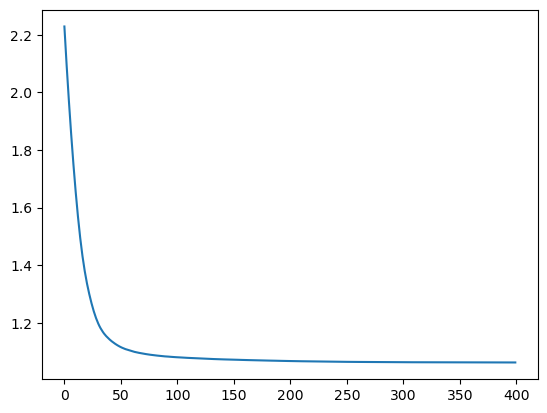

In [21]:
plt.plot(losses)

In [22]:
# variance vs station density
from sklearn.neighbors import NearestNeighbors
pts = stations[["lon","lat"]].to_numpy()
poly = df_full[["cent_lon","cent_lat"]].to_numpy()
nbrs = NearestNeighbors(n_neighbors=3).fit(pts)
dist, _ = nbrs.kneighbors(poly)
df_full["nn_dist_k3"] = dist.mean(1)
print(np.corrcoef(df_full["nn_dist_k3"], df_full["krige_var_C2"])[0,1])
# should be positive: farther from stations ⇒ higher variance


0.9725166353270664


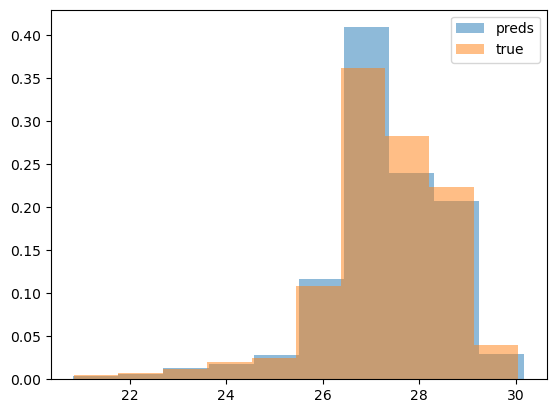

In [23]:
# Define equivalents for plotting
mean_preds = svgp_mean
y_train = y.numpy()

# Compute mean/std of targets (kriged temps)
y_mean = torch.tensor(y_train.mean())
y_std  = torch.tensor(y_train.std())

plt.hist(mean_preds, density=True, alpha=0.5, label='preds')
plt.hist(y_train,   density=True, alpha=0.5, label='true')
plt.legend(); plt.show()

<Axes: >

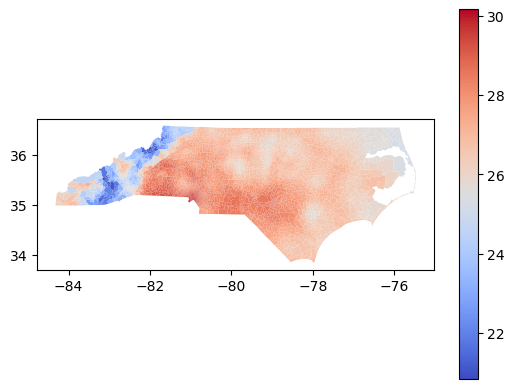

In [24]:
# Map: pass a column name, not an array, and keep °C
areal_units = areal_units.copy()
areal_units['pred_temp'] = mean_preds
areal_units.plot(column='pred_temp', cmap='coolwarm', legend=True)

In [25]:
model.mean_module.weights

Parameter containing:
tensor([[-1.0274],
        [ 0.2177],
        [ 0.0130],
        [-0.0066]], requires_grad=True)

<Axes: >

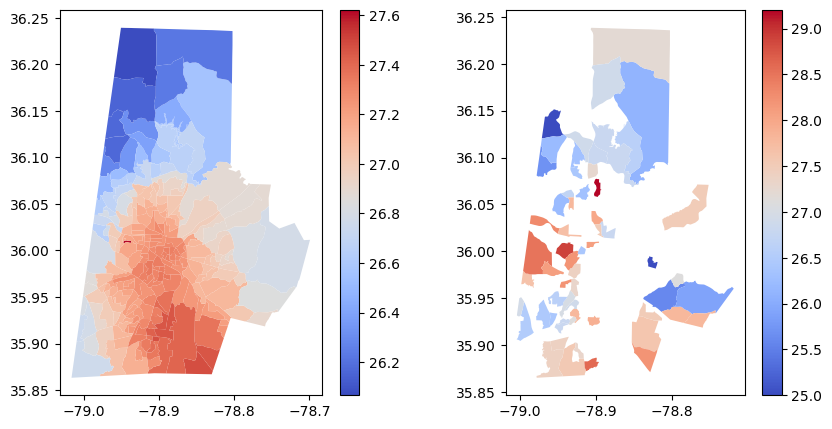

In [26]:
# County comparison
areal_units['county'] = areal_units['GEOID'].str[:5]
# county = areal_units[areal_units['county'] == county_prefix].copy()
county = areal_units[areal_units['county'].isin(county_prefixes)].copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
county.plot(column='pred_temp', legend=True, cmap='coolwarm', ax=ax1)
county.plot(column=f'{time_slot}_temp', legend=True, cmap='coolwarm', ax=ax2) 

In [27]:
# print(model.covar_module.kernels[0].outputscale)
# print(model.covar_module.kernels[0].base_kernel.lengthscale)
# print(model.covar_module.kernels[1].outputscale)
# print(model.covar_module.kernels[1].base_kernel.lengthscale)
# print(likelihood.noise)

So, a bit of shrinkage is almost unavoidable, but it does not seem whack.

Stations: [21.1   26.15  27.2   28.2   30.486]
Kriged: [22.51451756 26.7084074  27.29236984 28.17838097 29.51429123]
SVGP: [22.80188065 26.73130226 27.26198196 28.19611549 29.47699795]


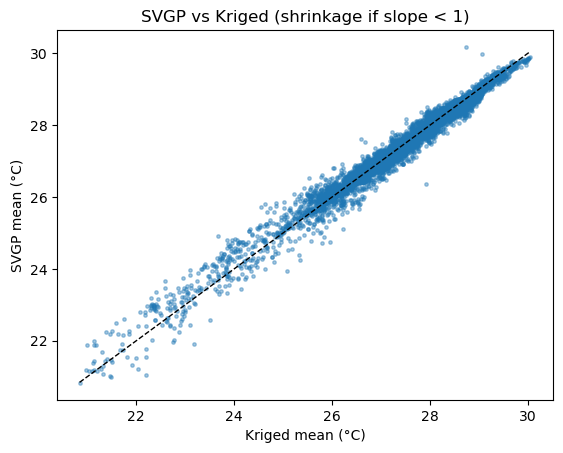

In [28]:
import numpy as np

print("Stations:", np.percentile(stations["tempAvg"], [1,25,50,75,99]))
print("Kriged:",  np.percentile(df_full["krige_mean_C"],    [1,25,50,75,99]))
print("SVGP:",    np.percentile(df_full["svgp_mean_C"],      [1,25,50,75,99]))

# Shrinkage scatter
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(df_full["krige_mean_C"], df_full["svgp_mean_C"], s=6, alpha=0.4)
mn, mx = df_full["krige_mean_C"].min(), df_full["krige_mean_C"].max()
plt.plot([mn,mx],[mn,mx],'k--',lw=1)
plt.xlabel("Kriged mean (°C)"); plt.ylabel("SVGP mean (°C)")
plt.title("SVGP vs Kriged (shrinkage if slope < 1)")
plt.show()


In [29]:
# =========================
# Save predictions to CSVs
# =========================

import os

# Build output dir and filename pieces
date_tag = os.path.basename(f"{wu_date}")
tag = "tract" if census_group_type == "tract" else "bg"
out_dir = os.path.join("ps_on_nc", city_name)
os.makedirs(out_dir, exist_ok=True)

# Columns to keep from df_full (one row per polygon)
pred_cols = [
    "GEOID", "cent_lat", "cent_lon",
    "krige_mean_C", "krige_var_C2",
    "svgp_mean_C",  "svgp_var_C2"
]
# Guard against missing columns if the code changes
pred_cols = [c for c in pred_cols if c in df_full.columns]

# Full set (statewide) CSV
pred_df = df_full[pred_cols].copy()
csv_path_all = f"ps_on_nc/nc/nc_svgpr_{tag}_{m}_{date_tag}_{time_slot}.csv"
pred_df.to_csv(csv_path_all, index=False, float_format="%.6f")
print(f"Saved NC predictions → {csv_path_all}")

# Save statewide shapefile with predictions
state_gdf = areal_units.merge(
    df_full[["GEOID", "krige_mean_C", "krige_var_C2", "svgp_mean_C", "svgp_var_C2"]],
    on="GEOID", how="left"
).to_crs(4326)
geom_cols = [c for c in state_gdf.columns
             if getattr(state_gdf[c].dtype, "name", "") == "geometry" and c != state_gdf.geometry.name]
if geom_cols:
    state_gdf = state_gdf.drop(columns=geom_cols)
state_gdf = state_gdf.rename(columns={
    "krige_mean_C": "krg_mean",
    "krige_var_C2": "krg_var",
    "svgp_mean_C": "svgp_mean",
    "svgp_var_C2": "svgp_var"
})
state_gdf["GEOID"] = state_gdf["GEOID"].astype(str)
out_path = f"ps_on_nc/nc/nc_svgpr_{tag}_{m}_{date_tag}_{time_slot}.shp"
state_gdf.to_file(out_path)
print("Saved statewide shapefile →", out_path)


# County subset (e.g., Durham via FIPS prefix)
if "GEOID" in pred_df.columns:
    county_df = pred_df[
        pred_df["GEOID"].astype(str).str.startswith(tuple(county_prefixes))
    ].copy()
    # county_df = pred_df[pred_df["GEOID"].astype(str).str.startswith(county_prefix)].copy()
    csv_path_cty = os.path.join(out_dir, f"{city_name}_svgpr_{tag}_{m}_{date_tag}_{time_slot}.csv")
    county_df.to_csv(csv_path_cty, index=False, float_format="%.6f")
    print(f"Saved county subset → {csv_path_cty}")


Saved NC predictions → ps_on_nc/nc/nc_svgpr_bg_800_jul23_2021_eve.csv
Saved statewide shapefile → ps_on_nc/nc/nc_svgpr_bg_800_jul23_2021_eve.shp
Saved county subset → ps_on_nc/durham/durham_svgpr_bg_800_jul23_2021_eve.csv


In [30]:
# =========================
# Save corresponding county shapefile
# =========================

import geopandas as gpd

# Merge the prediction DataFrame back with the areal geometries
gdf_pred_all = areal_units.merge(
    df_full[["GEOID", "krige_mean_C", "krige_var_C2", "svgp_mean_C", "svgp_var_C2"]],
    on="GEOID", how="left"
)

# Filter to county polygons by FIPS prefix
# gdf_pred_cty = gdf_pred_all[gdf_pred_all["GEOID"].astype(str).str.startswith(county_prefix)].copy()
gdf_pred_cty = gdf_pred_all[
    gdf_pred_all["GEOID"].astype(str).str.startswith(tuple(county_prefixes))
].copy()

# Ensure CRS is WGS84 (EPSG:4326) for shapefile export
gdf_pred_cty = gdf_pred_cty.to_crs("EPSG:4326")

# Define output path
shp_path_cty = os.path.join(out_dir, f"{city_name}_svgpr_{tag}_{m}_{date_tag}_{time_slot}.shp")

# Drop any extra geometry-typed columns before saving
geom_cols = [c for c in gdf_pred_cty.columns if getattr(gdf_pred_cty[c].dtype, "name", "") == "geometry"]
if len(geom_cols) > 1:
    # Keep only the active geometry
    gdf_pred_cty = gdf_pred_cty.drop(columns=[c for c in geom_cols if c != gdf_pred_cty.geometry.name])

# Save shapefile
gdf_pred_cty.to_file(shp_path_cty)
print(f"Saved county shapefile → {shp_path_cty}")


Saved county shapefile → ps_on_nc/durham/durham_svgpr_bg_800_jul23_2021_eve.shp


/var/folders/wh/fhcq_pkj52nc_krcfphv4rxh0000gn/T/ipykernel_96110/3683394975.py:32: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_pred_cty.to_file(shp_path_cty)
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'krige_mean_C' to 'krige_mean'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'krige_var_C2' to 'krige_var_'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'svgp_mean_C' to 'svgp_mean_'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'svgp_var_C2' to 'svgp_var_C'
  ogr_write(


In [31]:
gdf_pred_cty.columns

Index(['GEOID', 'ALAND', 'AWATER', 'eve_temp', 'count', 'population',
       'geometry', 'cent_lon', 'cent_lat', 'pred_temp', 'county',
       'krige_mean_C', 'krige_var_C2', 'svgp_mean_C', 'svgp_var_C2'],
      dtype='object')